# <span style="color:#873260">`Cart and Pole Game` </span>: 

This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

## <span style="color:#873260">Action space</span> :
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with ( right or left)

## <span style="color:#873260">Observation space</span> :
The observation is a ndarray with shape (4,) with the values corresponding to the following :

(Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity)

## <span style="color:#873260">The reward</span> :
In the CartPole environment of OpenAI Gym, the reward is typically +1 for each time step in which the pole is kept upright. The goal is to accumulate as much reward as possible by maintaining the pole in a balanced position over a certain period. The episode is considered "solved" when the average reward over 100 episodes reaches 195 or higher.
<center>
<img src='https://static.packt-cdn.com/products/9781789345803/graphics/assets/9170409d-15f1-453b-816a-6f601a89fcf2.png'/>

</center>


In [22]:
import pygame
import pyglet

import math
import random
from typing import Text, Dict, List, NamedTuple, Tuple, Optional, Union
from collections import namedtuple
from itertools import count
from PIL import Image

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from IPython import display

# Define our Deep Reinforcement<span style="color:#873260"> Neural Network</span> model : 

In [23]:
class DQN(nn.Module):
    def __init__(self, num_state_features):
        # The default initialization method in PyTorch is often Xavier/Glorot initialization for linear layers.
        super().__init__()
        self.fc1 = nn.Linear(in_features=num_state_features,
                             out_features=32)
        self.fc2 = nn.Linear(in_features=32,
                             out_features=64)
        self.fc3 = nn.Linear(in_features=64,
                             out_features=128)
        self.out = nn.Linear(in_features=128,
                             out_features=2) 
        

    def forward(self, t):
        # define our forward passs : 
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)
        return t

# define our<span style="color:#873260"> Rplay Memory</span> : 
To enable more stable and efficient learning by breaking temporal correlations, improving data efficiency, and allowing the agent to learn from a diverse set of experiences.

In [24]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)


class ReplayMemeory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience) -> None:
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
            self.push_count += 1

    def sample(self, batch_size: int):
        """Sample is equal to the `batch_size` sent to this function`"""
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size: int) -> bool:
        return len(self.memory) >= batch_size

## Define our<span style="color:#873260"> Epsilon Greedy Strategy</span> so we can to either <span style="color:#873260"> Explore/Exploite </span> the envirment : 

In [25]:
class EpsilonGreedyStrategy:
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step: int) -> float:
        return self.end + (self.start - self.end) *  math.exp(-1. * current_step * self.decay)

# Define our<span style="color:#873260"> Agent</span> class:

In [26]:
class Agent:
    def __init__(self, strategy, num_actions, device) -> None:
        self.strategy = strategy
        self.num_actions = num_actions
        self.current_step = 0
        self.device = device

    def select_action(self, state, policy_net) -> float:
        epsilon_rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        # select an action
        if epsilon_rate > random.random(): 
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device=self.device) # explore
        else:
            with torch.no_grad(): # teurn off the gradient, 
                return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(device=self.device) # exploit

# Define a class that handels<span style="color:#873260"> Environment </span> : 


In [27]:
class CartPoleEnvManager:
    def __init__(self, device) -> None:
        self.device = device
        self.env = gym.make('CartPole-v1').unwrapped 
        self.env.reset() # reset the environment to get the initial observations
        self.current_state = None
        self.done = False

    def reset(self) -> None:
        self.current_state = self.env.reset()

    def close(self) -> None:
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def display(self):
        return self.env.display()

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action: torch.Tensor) -> torch.Tensor:
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def get_state(self):
        if self.done:
            return torch.zeros_like(
              torch.tensor(self.current_state, device=self.device)
            ).float()
        else:
            return torch.tensor(self.current_state, device=self.device).float()

    def num_state_features(self):
        return self.env.observation_space.shape[0]


In [28]:
def extract_tensors(experiences: NamedTuple) -> Tuple[torch.TensorType]:
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    t_states = torch.stack(batch.state)
    t_actions = torch.cat(batch.action)
    t_next_state = torch.stack(batch.next_state)
    t_rewards = torch.cat(batch.reward)
    return (t_states,
            t_actions,
            t_next_state,
            t_rewards)

## QValues Class for<span style="color:#873260">  Calculating Current and Next Q-Values</span> in Deep Q-Learning:
We need current Q-values and next Q-values to use in the Bellman equation and calculate the loss.

In [29]:
class QValues:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
       
        final_states_location = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_states_locations = (final_states_location == False)
        non_final_states = next_states[non_final_states_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_states_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## A function to plot<span style="color:#873260"> Agent Performance Over Time</span>:
plot the duration of the game for each episode


To solve cart and pole, the average reward must be greater than or equal to `195` over <u>`100` consecutive episodes</u>. Recall that our agent gets a reward of +1 for each step it takes that doesn't end the episode. So, the duration of an episode measured in timesteps is exactly equivalent to the reward for that episode.

In [30]:
from sysconfig import is_python_build


def plot(values,moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training ...")
    plt.xlabel('Episodes')
    plt.ylabel('Duration / reward')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period,values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode",len(values),"\n",moving_avg_period,"episode moving avg: ",moving_avg[-1])
    if is_python_build: display.clear_output(wait=True)


def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >=period:
        moving_avg = values.unfold(dimension = 0 , size = period , step = 1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1),moving_avg))
        return moving_avg.numpy()
    
    else :
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()



## Initialization and Choosing the Hyperparameters:

In [31]:
batch_size = 256
gamma = 0.999 # --> discounted rate
eps_start = 1 # --> Epsilon start
eps_end = 0.01 # --> Epsilon end
eps_decay = 0.001 # --> rate of Epsilon decay
target_update = 10 # --> For every 10 episode, we're going to update
                         ## the target network with the policy network weights
#  Initialize replay memory capacity and learning rate
memory_size = 100000
lr = 0.001
num_episodes = 1000

# Object created : 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemeory(memory_size)

policy_net = DQN(em.num_state_features()).to(device)
target_net = DQN(em.num_state_features()).to(device)

# init target betwork : 
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


# init optimizer : 
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

# <span style="color:#873260">Training the agent</span> : 
## The episode ends if any one of the following occurs:

Termination: Pole Angle is greater than ±12°
Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
the network solves the environment by reaching the `100-episode` average reward of 195 or higher.

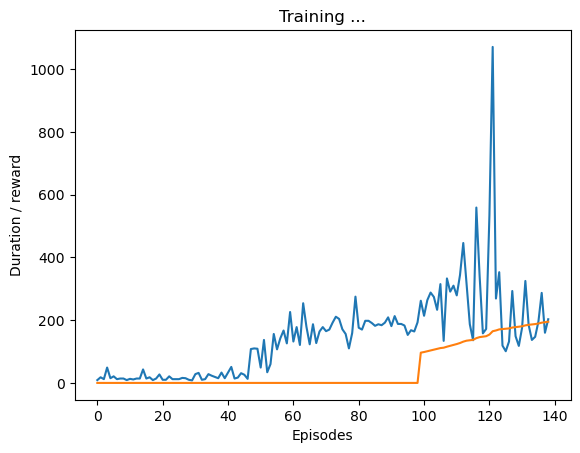

Episode 139 
 100 episode moving avg:  195.18


In [32]:
episode_duration = []

# 4. For each episode:
for episode in range(num_episodes):
    em.reset()
    # (4.1) Initialize the starting state.
    state = em.get_state()
    # (4.2) For each time step:
    for timestep in count():
        em.render()
        # Agent Select an action.
        action = agent.select_action(state, policy_net)
        # Observe reward and next state.
        reward = em.take_action(action)
        next_states = em.get_state()
        #  Store experience in replay memory.
        memory.push(Experience(state, action, next_states, reward))
        # Transition to next state 
        state = next_states

        #  Sample random batch from replay memory if possible.
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            #  Preprocess states from batch.
            states, actions, next_states, rewards = extract_tensors(experiences)
            # Get the current Q-values of the policy net and the next Q-values for the target nework
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            # calculate the target Q-values by the Bellman Optimality Equation
            target_q_values = rewards + (gamma * next_q_values)

            # (4.2.8) Calculate loss between output Q-values and target Q-values.
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

            # Gradient descent updates weights in the policy network to minimize loss.
            ## Calculate the gradients of the loss
            loss.backward()
            ## Update the network with the gradients
            optimizer.step()
            ## Reset the gradients weights & biases before back propagation
            optimizer.zero_grad()

        # Check if the agent took the last action in the episode
        if em.done:
            episode_duration.append(timestep)
            plot(episode_duration, 100) # plot the avrege duration of the last 100 epsides
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # the network solves the environment by reaching the 100-episode average reward of 195 or higher.
    if get_moving_average(100, episode_duration)[-1] >= 195:
        break

em.close()